In [1]:
%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

# Stellar mass vs. $v_\text{max}$

First, imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy import units
from pathlib import Path
import os

import dataset
import curve_fit

import importlib

In [3]:
importlib.reload(dataset)
importlib.reload(curve_fit)

<module 'curve_fit' from '/home/ad/lxhome/k/kassiili/Linux/SummerProject/APOSTLE_data_analysis/curve_fit.py'>

## Get data

Next, I retrieve the data. We are only interested in luminous halos. Also, there might be some spurious cases with odd values of $v_\text{max}$.

In [17]:
# Get LCDM data:
LCDM = dataset.Dataset("V1_LR_fix_127_z000p000", "LCDM")
vmaxSat, vmaxIsol = LCDM.get_subhalos("Vmax",True)
SMSat, SMIsol = LCDM.get_subhalos("Stars/Mass",True)

# Exclude dark halos
maskSat = np.logical_and.reduce((vmaxSat>0, SMSat>0))
maskIsol = np.logical_and.reduce((vmaxIsol>0, SMIsol>0))

# Convert to proper units:
vmaxSat = vmaxSat[maskSat] / 100000 # cm/s to km/s 
vmaxIsol = vmaxIsol[maskIsol] / 100000
SMSat = SMSat[maskSat] * units.g.to(units.Msun)
SMIsol = SMIsol[maskIsol] * units.g.to(units.Msun)

## Plot

In [4]:
# Set some parameters:
x_down = 10; x_up = 100
y_down = 10**5; y_up = 5*10**9

## Fit polynomial curve:

In [5]:
# try linear regression:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

test_size = 0.25
x_train, x_test, y_train, y_test = train_test_split(vmaxSat, SMSat,\
        test_size=test_size)

x_train = np.log(x_train).reshape(-1,1)
y_train = np.log(y_train)

x_test = np.log(x_test).reshape(-1,1)
y_test = np.log(y_test)

linreg = LinearRegression().fit(x_train,y_train)

print(linreg.get_params())
print(linreg.coef_)
print(linreg.intercept_)

train_score = linreg.score(x_train,y_train)
test_score = linreg.score(x_test, y_test)

# Construct model curve:
xfit = np.linspace(min(vmaxSat),max(vmaxSat),10000).reshape(-1,1)
yfit = np.exp(linreg.predict(np.log(xfit)))

(train_score,test_score)

NameError: name 'vmaxSat' is not defined

In [15]:
xfit, yfit, train_err, test_err = curve_fit.poly_fit(np.log(vmaxSat),np.log(SMSat),max_deg=4)
xfit = np.exp(xfit); yfit = np.exp(yfit)
(train_err, test_err)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
                                  normalize=True))],
         verbose=False)


(0.37862386368988915, 0.6986271383478324)

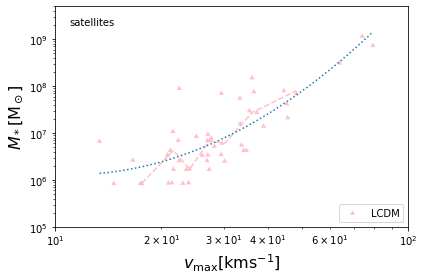

In [16]:
fig, axes = plt.subplots()

# Set axes:
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlim(x_down,x_up)
axes.set_ylim(y_down,y_up)

# Set labels:
axes.set_xlabel('$v_{\mathrm{max}}[\mathrm{km s^{-1}}]$', fontsize=16)
axes.set_ylabel('$M_*[\mathrm{M_\odot}]$', fontsize=16)
axes.text(11, 2*10**9, 'satellites')
#axes.set_title('Stellar mass of satellites')
#axes.text(11, 2*10**9, 'isolated galaxies')
#axes.set_title('Stellar mass of isolated galaxies')

# Set marker styles:
color = {LCDM.name : "pink"}
marker = {LCDM.name : (3,0,0)}

# Add LCDM scatter plot:
axes.scatter(vmaxSat, SMSat, marker=marker[LCDM.name], c=color[LCDM.name], \
        edgecolor='none', label=LCDM.name)

# Add LCDM median:
median = curve_fit.median_trend(vmaxSat, SMSat, points_per_bar=7)
axes.plot(median[0], median[1], c=color[LCDM.name], linestyle='--')

# Add polynomial fit:
axes.plot(xfit,yfit, linestyle=':')

axes.legend(loc='lower right')
plt.tight_layout()

# Save figure:

filename = 'SM_vs_Vmax_sat.png'
#filename = 'SM_vs_Vmax_isol.png'

home = os.path.dirname(dataset.__file__)
path = os.path.join(home,"Figures")

# If the directory does not exist, create it
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(os.path.join(path,filename))